In [1]:
import sys
!{sys.executable} -m pip install --upgrade -q tcia_utils

import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

from concurrent.futures import ThreadPoolExecutor
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import torch

clinical_path = config["clinical_path"]["cleaned_clinical"]
clinical_path_267 = config["clinical_path"]["cleaned_clinical_267"]

def filter_267_subjects(df):
    """filter the cleaned df based on subjects with available CT scans"""
    ct = pd.read_csv(config["ct_scans"]["subjects_ct_scans"])
    ct_patients = ct["Subject ID"].unique()
    df = df[df["submitter_id"].isin(ct_patients)]
    print(df.shape[0], "patients")
    print(df["event"].value_counts())
    output_clinical_cleaned_267 = config["clinical_path"]["cleaned_clinical_267"]
    df.to_csv(output_clinical_cleaned_267, index=False)
filter_267_subjects(pd.read_csv(clinical_path))

clinical_path_267 = config["clinical_path"]["cleaned_clinical_267"]
data_267 = pd.read_csv(clinical_path_267)

267 patients
event
0    182
1     85
Name: count, dtype: int64


# Some distributions

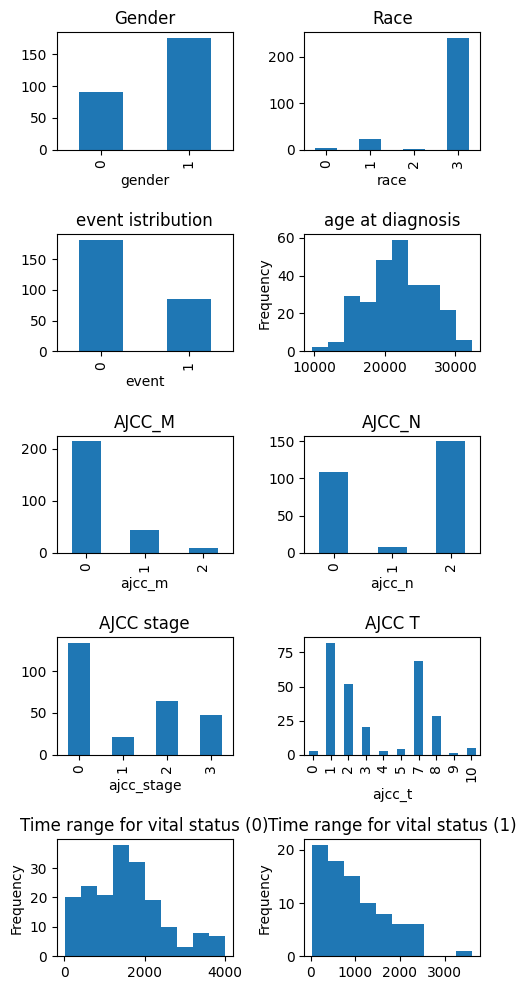

In [2]:
# quick visualization

def visualize(df):
    df['age_diagnosis'] = pd.to_numeric(df['age_diagnosis'], errors='coerce')
    fig, axs = plt.subplots(5, 2, figsize=(5, 10))
    fig.subplots_adjust(hspace=0.5)
    for col, ax in zip(['gender', 'race'], axs[0]):
        df[col].value_counts().sort_index().plot(kind='bar', ax=ax, title=f'{col.capitalize()}')
    df['event'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 0], title='event istribution')
    df['age_diagnosis'].plot(kind='hist', bins=10, ax=axs[1, 1], title='age at diagnosis')
    for col, ax in zip(['ajcc_m', 'ajcc_n'], axs[2]):
        df[col].value_counts().sort_index().plot(kind='bar', ax=ax, title=f'{col.upper()}')
    df['ajcc_stage'].value_counts().sort_index().plot(kind='bar', ax=axs[3, 0], title='AJCC stage')
    df['ajcc_t'].value_counts().sort_index().plot(kind='bar', ax=axs[3, 1], title='AJCC T')
    for event, ax in zip([0, 1], axs[4]):
        df[df['event'] == event]['time'].plot(kind='hist', bins=10, ax=ax, title=f'Time range for vital status ({event})')
    plt.tight_layout()
    plt.show()

visualize(data_267)

# Multicollinearity

In [42]:
data = data_267.drop(["id", "submitter_id"], axis=1)

In [46]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(df, threshold=5):
    """
    Checks multicollinearity using Variance Inflation Factor
    """
    df_numeric = df.select_dtypes(include=[np.number]).dropna()
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

    # return vif_data[vif_data["VIF"] > threshold]  
    return vif_data


check_multicollinearity(data).sort_values(by=["VIF"])

,Feature,VIF
2,event,2.060236
4,ajcc_m,2.179354
5,ajcc_n,2.515992
0,gender,2.898460
8,time,3.599747
6,ajcc_stage,14.109951
3,age_diagnosis,16.333319
7,ajcc_t,16.687809
1,race,17.673805


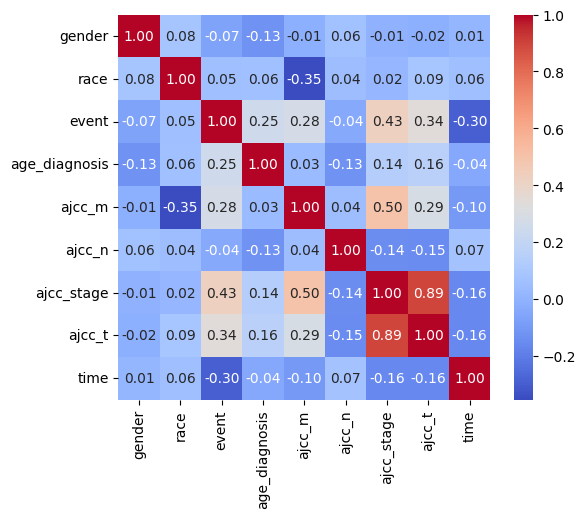

In [48]:
corr_matrix = data.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


- ajcc_t and ajcc_stage are highly correlated
- but let's keep them both and use embeddings + dim reduction

# Fit model

"As a baseline against standard statistical approaches, we trained Cox Proportion Hazard Models using age, gender, and grade as covariates."

Consider grade here as cancer stage

In [54]:
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index

In [53]:
data_fit = data[["gender", "age_diagnosis", "ajcc_stage", "event", "time"]]
data_fit

,gender,age_diagnosis,ajcc_stage,event,time
0,1,15360,0,0,211
1,1,24850,0,0,1371
2,1,15264,0,0,1130
3,0,25508,3,1,1714
4,0,27162,0,0,620
...,...,...,...,...,...
262,0,29380,0,1,1639
263,1,17449,1,0,1893
264,0,15219,0,0,1046
265,0,25013,2,1,1230


In [58]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
c_index_results = []

for train_idx, valid_idx in kfold.split(data_fit):
    train = data_fit.iloc[train_idx]
    valid = data_fit.iloc[valid_idx]
    cox_model = CoxPHFitter() # TODO: check regularization
    cox_model.fit(train, duration_col="time", event_col="event")
    # prediction on survival (negative hazard)
    pred_survival = -cox_model.predict_partial_hazard(valid)

    # evaluation
    c_index = concordance_index(valid["time"], pred_survival, valid["event"])
    c_index_results.append(c_index)


In [61]:
print(np.array(c_index_results))
print(np.mean(c_index_results))

[0.67       0.77173913 0.63740458 0.8214876  0.81852552]
0.7438313667484022
